# Interpolating profiler data to a regular grid
---

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.interpolate import griddata

In [18]:
sns.set_style('whitegrid')

In [2]:
profiler_data = pd.read_csv('../../coastal_upwelling_output/profiler_data_2018.csv')

In [3]:
profiler_data.time

0           2018-07-17 15:38:50.061576192
1           2018-07-17 15:38:51.061581824
2           2018-07-17 15:38:52.061271552
3           2018-07-17 15:38:53.061588992
4           2018-07-17 15:38:54.061177344
                        ...              
13164698    2018-12-31 11:59:55.458120192
13164699    2018-12-31 11:59:56.458231296
13164700    2018-12-31 11:59:57.458030592
13164701    2018-12-31 11:59:58.457932288
13164702    2018-12-31 11:59:59.458563072
Name: time, Length: 13164703, dtype: object

In [4]:
profiler_data['time'] = pd.to_datetime(profiler_data['time'])

In [5]:
profiler_hourly = profiler_data.resample('H', on='time').mean().dropna(how='all').reset_index()

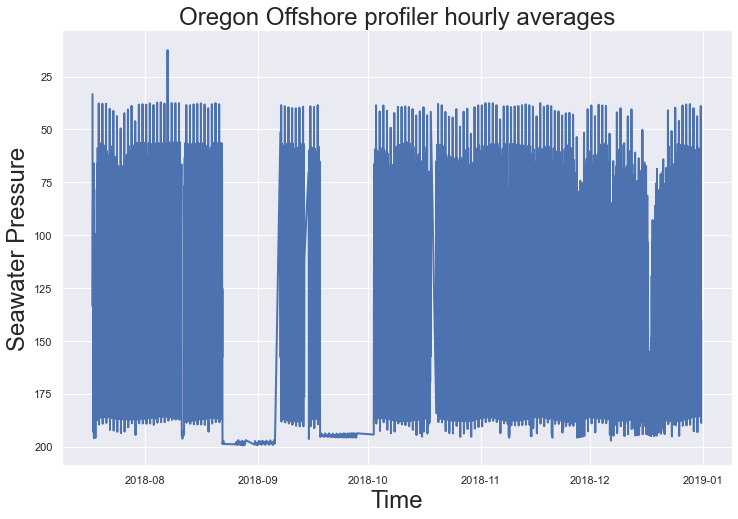

In [6]:
# Plot hourly-averaged METBK data
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,8))
ax.plot(profiler_hourly['time'], profiler_hourly['seawater_pressure'], 'b', linewidth=2)
ax.set_xlabel('Time', size=24)
ax.set_ylabel('Seawater Pressure', size=24)
ax.set_title('Oregon Offshore profiler hourly averages', size=24)
ax.invert_yaxis()

Since there are two significant gaps in the data, the results of the interpolation will include a large ratio of "made up" data points. It's recommended to add the original gaps back to the data after interpolation to avoid feeding models large chunks of fabricated data, according to: https://www.mathworks.com/matlabcentral/answers/363643-use-griddata-ignoring-gaps-in-data. See the [misc_code](https://github.com/dgumustel/coastal-upwelling/blob/main/extras/misc_code.ipynb) notebook for the start and end dates of some of the gaps in the profiler data. 

### Using `griddata()` 

To start, interpolate a single day's worth of data. I arbitrarily chose December 1.

In [7]:
df = profiler_data

df_resampled = df.resample('T', on='time').mean().dropna(how='all').reset_index()
df_resampled['time']

0        2018-07-17 15:38:00
1        2018-07-17 15:39:00
2        2018-07-17 15:40:00
3        2018-07-17 15:41:00
4        2018-07-17 15:42:00
                 ...        
219456   2018-12-31 11:55:00
219457   2018-12-31 11:56:00
219458   2018-12-31 11:57:00
219459   2018-12-31 11:58:00
219460   2018-12-31 11:59:00
Name: time, Length: 219461, dtype: datetime64[ns]

In [8]:
mask = (df_resampled['time'][:] > '2018-12-01') & (df_resampled['time'] <= '2018-12-02')
df_resampled = df_resampled.loc[mask].reset_index(drop=True)

The only way I could get `griddata` to work was by converting the times to integers.

In [9]:
df_resampled['time_'] = df_resampled['time'].values.astype(object)
df_resampled['time_']

0       1543622460000000000
1       1543622520000000000
2       1543622580000000000
3       1543622640000000000
4       1543622700000000000
               ...         
1435    1543708560000000000
1436    1543708620000000000
1437    1543708680000000000
1438    1543708740000000000
1439    1543708800000000000
Name: time_, Length: 1440, dtype: object

However, theme numbers are enormous and leads to computation overflow errors, so I divide them into smaller integers and can reverse the division and type change later to get the human-readable times back for creating the final dataframe.

In [10]:
# data coordinates and values
x = df_resampled.time_.astype(np.int64) / 100000000000 
y = df_resampled.seawater_pressure 
z = df_resampled.seawater_temperature 

In [12]:
# target grid to interpolate to
xi = np.arange(min(x), max(x), 60) # intervals of 60 seconds
yi = np.arange(min(y), max(y), 1) # intervals of 1 meter

In [13]:
xi.shape

(15,)

In [14]:
yi.shape

(189,)

In [15]:
xi,yi = np.meshgrid(xi,yi)

In [16]:
# interpolate
zi_linear = griddata((x,y),z,(xi,yi),method='linear', rescale=True)

In [17]:
zi_linear.shape

(189, 15)

Plot the original data as scatter points to demonstrate exactly what interpolation does. 

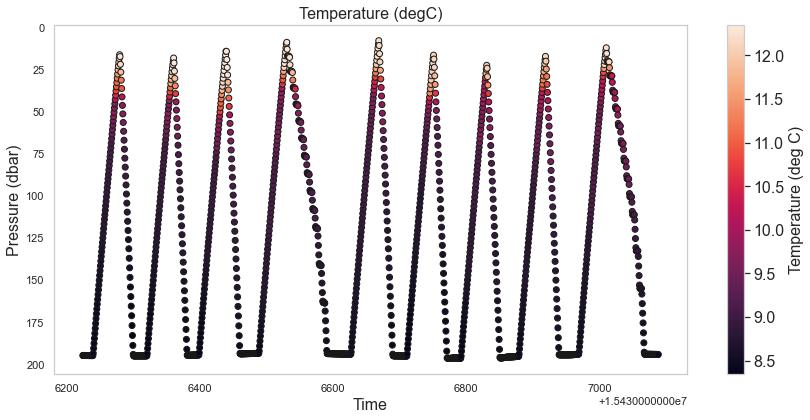

In [19]:
fig, ax = plt.subplots(figsize=(12,6))

ax.invert_yaxis()
ax.grid()

sc = ax.scatter(x,y,c=z,edgecolors='k')
ax.set_xlabel('Time', size=16)
ax.set_ylabel('Pressure (dbar)', size=16)
ax.set_title('Temperature (degC)', size=16)
cb = fig.colorbar(sc,ax=ax)
cb.set_label(label='Temperature (deg C)', size=16)
cb.ax.tick_params(labelsize=16)

plt.tight_layout()
plt.savefig('../figures/dec-01_raw.png')

These are the measurements collected by the shallow profiler resampled to 1-minute averages. Next, we can see how using the linear interpolation method fills in the gaps between measurements. 

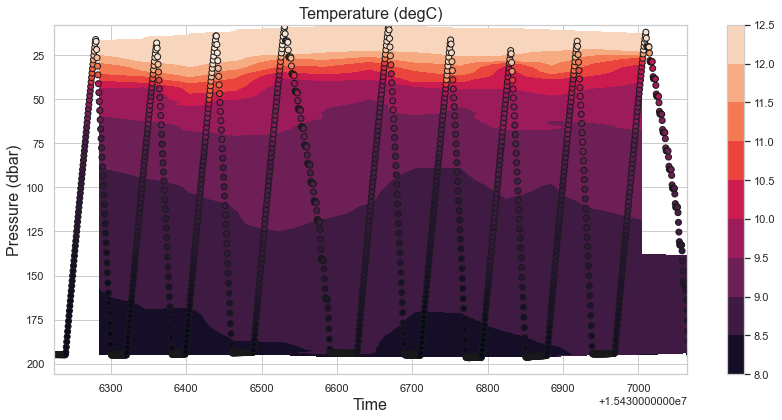

In [20]:
fig, ax = plt.subplots(figsize=(12,6))

cs2 = ax.contourf(xi,yi,zi_linear)
plt.colorbar(cs2, ax=ax)
ax.scatter(x, y, c=z,edgecolors='k')
ax.invert_yaxis()
# ax.set_title("Using method='linear'",fontsize=16)
ax.set_xlabel('Time', size=16)
ax.set_ylabel('Pressure (dbar)', size=16)
ax.set_title('Temperature (degC)', size=16)
# cb = fig.colorbar(sc,ax=ax)
# cb = plt.colorbar(cs2, ax=ax)
cb.set_label(label='Temperature (deg C)', size=16)
cb.ax.tick_params(labelsize=16)

plt.tight_layout()
plt.savefig('../figures/dec-01_griddata.png')

See how most of the white spaces are filled in? This produces a grid of data that is aligned along pressure and time, so we can turn this into a pandas dataframe with time as the index and different pressure as the columns. Then we can use each pressure column as individual features in models, and even do PCA to reduce dimensionality.

### Interpolating 1 month
Now do the same for a full month of data to see how it performs; I chose the month of December for this one.

In [22]:
df_resampled = df

In [23]:
df_resampled['time']

0          2018-07-17 15:38:50.061576192
1          2018-07-17 15:38:51.061581824
2          2018-07-17 15:38:52.061271552
3          2018-07-17 15:38:53.061588992
4          2018-07-17 15:38:54.061177344
                        ...             
13164698   2018-12-31 11:59:55.458120192
13164699   2018-12-31 11:59:56.458231296
13164700   2018-12-31 11:59:57.458030592
13164701   2018-12-31 11:59:58.457932288
13164702   2018-12-31 11:59:59.458563072
Name: time, Length: 13164703, dtype: datetime64[ns]

In [24]:
mask = (df_resampled['time'][:] > '2018-12-01') & (df_resampled['time'] <= '2018-12-31')
df_resampled = df_resampled.loc[mask].reset_index(drop=True)

In [26]:
df_resampled['time_'] = df_resampled['time'].values.astype(object)
df_resampled['time_']

0          1543622400177739264
1          1543622401176911360
2          1543622402177646080
3          1543622403176923136
4          1543622404177553920
                  ...         
2590838    1546214395540899328
2590839    1546214396540905984
2590840    1546214397540183040
2590841    1546214398539668992
2590842    1546214399539779072
Name: time_, Length: 2590843, dtype: object

In [27]:
# data coordinates and values
x = df_resampled.time_.astype(np.int64) / 100000000000 # np.random.random(100)
y = df_resampled.seawater_pressure # np.random.random(100)
z = df_resampled.seawater_temperature # np.random.random(100)

In [28]:
# target grid to interpolate to
xi = np.arange(min(x), max(x), 60)
yi = np.arange(min(y), max(y), 1)

In [29]:
xi,yi = np.meshgrid(xi,yi)

In [30]:
xi.shape

(194, 432)

In [31]:
yi.shape

(194, 432)

In [32]:
# interpolate
# zi_nearest = griddata((x,y),z,(xi,yi),method='nearest', rescale=True)
zi_linear = griddata((x,y),z,(xi,yi),method='linear', rescale=True)
# zi_cubic = griddata((x,y),z,(xi,yi),method='cubic', rescale=True)

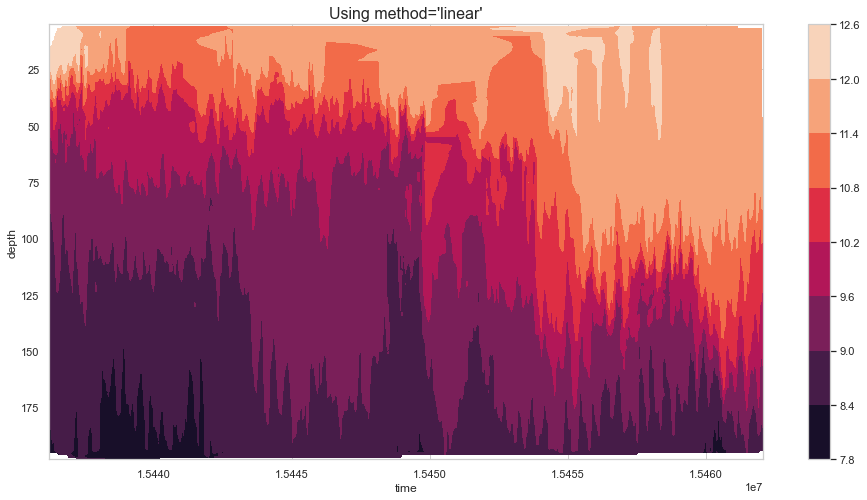

In [33]:
fig, ax = plt.subplots(figsize=(16,8))

cs2 = ax.contourf(xi,yi,zi_linear)
plt.colorbar(cs2, ax=ax)
# ax2.plot(x,y,'k.')
ax.set_xlabel('time')
ax.set_ylabel('depth')
ax.invert_yaxis()
ax.set_title("Using method='linear'",fontsize=16)

plt.savefig('../figures/december_gridded.png')

### Interpolating the full dataset
Now do it for all of the 2018 data.

In [34]:
df_resampled = df

In [35]:
df_resampled['time_'] = df_resampled['time'].values.astype(object)

In [36]:
df_resampled['time_']

0           1531841930061576192
1           1531841931061581824
2           1531841932061271552
3           1531841933061588992
4           1531841934061177344
                   ...         
13164698    1546257595458120192
13164699    1546257596458231296
13164700    1546257597458030592
13164701    1546257598457932288
13164702    1546257599458563072
Name: time_, Length: 13164703, dtype: object

In [37]:
# data coordinates and values
x = df_resampled.time_.astype(np.int64) / 100000000000 # np.random.random(100)
y = df_resampled.seawater_pressure # np.random.random(100)
z = df_resampled.seawater_temperature # np.random.random(100)

In [38]:
# target grid to interpolate to
xi = np.arange(min(x), max(x), 60)
yi = np.arange(min(y), max(y), 1)

In [39]:
xi,yi = np.meshgrid(xi,yi)

In [40]:
xi.shape

(197, 2403)

In [41]:
yi.shape

(197, 2403)

In [42]:
# interpolate
# zi_nearest = griddata((x,y),z,(xi,yi),method='nearest', rescale=True)
zi_linear = griddata((x,y),z,(xi,yi),method='linear', rescale=True)
# zi_cubic = griddata((x,y),z,(xi,yi),method='cubic', rescale=True)

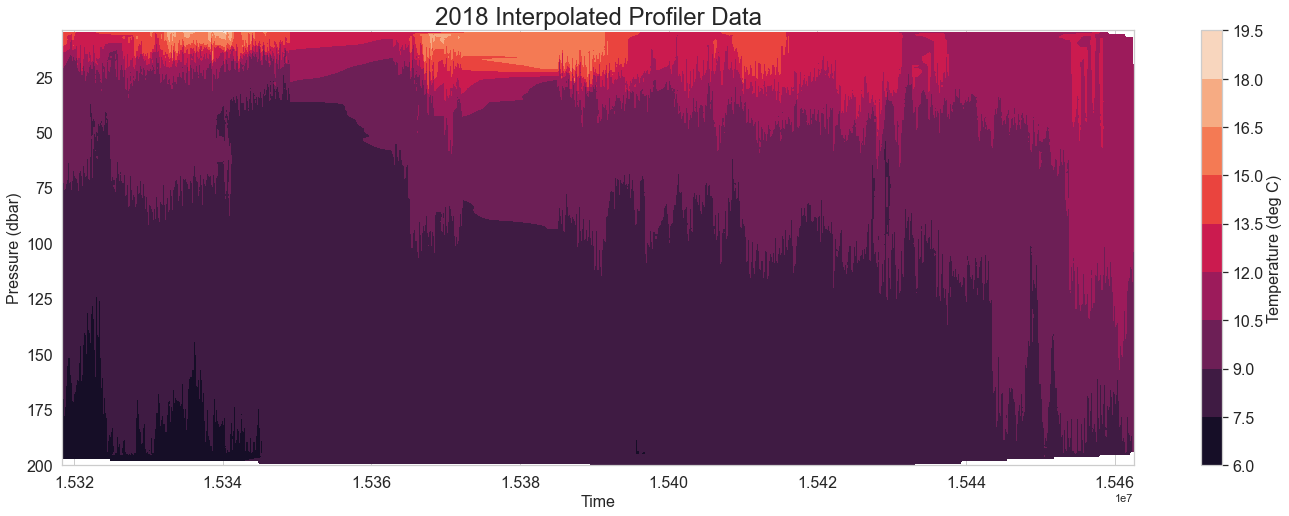

In [43]:
fig, ax = plt.subplots(figsize=(24,8))

cs2 = ax.contourf(xi,yi,zi_linear, levels=10)
cb = plt.colorbar(cs2, ax=ax)
# ax2.plot(x,y,'k.')
ax.set_xlabel('Time',fontsize=16)
ax.set_ylabel('Pressure (dbar)',fontsize=16)
ax.invert_yaxis()
ax.set_title("2018 Interpolated Profiler Data",fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=16)


# cb = fig.colorbar(sc,ax=ax)
cb.set_label(label='Temperature (deg C)', size=16)
cb.ax.tick_params(labelsize=16)

plt.savefig('../figures/2018_gridded.png')

---
### Create a dataframe from the griddata() results

In [171]:
z_df = pd.DataFrame(zi_linear, columns=np.arange(min(x), max(x), 60), index=np.arange(min(y), max(y), 1))
z_df = z_df.T
z_df

,4.122659,5.122659,6.122659,7.122659,8.122659,9.122659,10.122659,11.122659,12.122659,13.122659,...,191.122659,192.122659,193.122659,194.122659,195.122659,196.122659,197.122659,198.122659,199.122659,200.122659
1.531842e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.531848e+07,NaN,14.239120,14.197892,14.120385,14.183533,14.177953,14.100703,13.851424,13.837088,12.623838,...,7.040205,7.035856,7.038597,7.016340,7.009253,7.012501,7.002511,NaN,NaN,NaN
1.531854e+07,NaN,14.226363,14.221012,14.210943,14.090408,14.032935,13.983300,12.801985,13.000087,11.998454,...,7.156269,7.101412,7.100403,7.097658,7.095298,7.091719,7.091315,NaN,NaN,NaN
1.531860e+07,NaN,14.213606,14.170973,14.111121,14.363632,14.302021,14.101116,12.881438,12.688296,11.618997,...,7.142472,7.130818,7.118297,7.111259,7.115614,7.136021,7.077190,NaN,NaN,NaN
1.531866e+07,NaN,14.194031,14.120934,14.011299,14.521989,14.460151,14.142456,12.963377,12.452501,12.758078,...,7.215926,7.208012,7.204803,7.194276,7.194837,7.184467,7.074052,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.546230e+07,NaN,NaN,NaN,11.752532,11.753928,11.755204,11.678930,11.675686,11.677916,11.678166,...,8.899545,8.892312,8.881767,8.880591,NaN,NaN,NaN,NaN,NaN,NaN
1.546236e+07,NaN,NaN,NaN,NaN,11.743519,11.744727,11.658816,11.659835,11.661463,11.660108,...,9.036891,9.034417,9.030805,9.026434,NaN,NaN,NaN,NaN,NaN,NaN
1.546242e+07,NaN,NaN,NaN,NaN,11.733111,11.734140,11.700740,11.705893,11.706843,11.704725,...,9.082681,9.080695,9.080804,9.085565,NaN,NaN,NaN,NaN,NaN,NaN
1.546248e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.996548,8.995384,8.994268,8.991468,NaN,NaN,NaN,NaN,NaN,NaN


A few things to fix here before saving:
* Round the pressure columns to fewer decimals
* Set time as the index
* Convert the index back to human-readable times

In [172]:
# Round the pressure columns to fewer decimals
col_dict = {x:round(x, 2) for x in z_df.columns}
z_df.rename(col_dict, inplace=True, axis=1)

There are also plenty of nans to clean up. These are mostly located around the edges of the dataset:

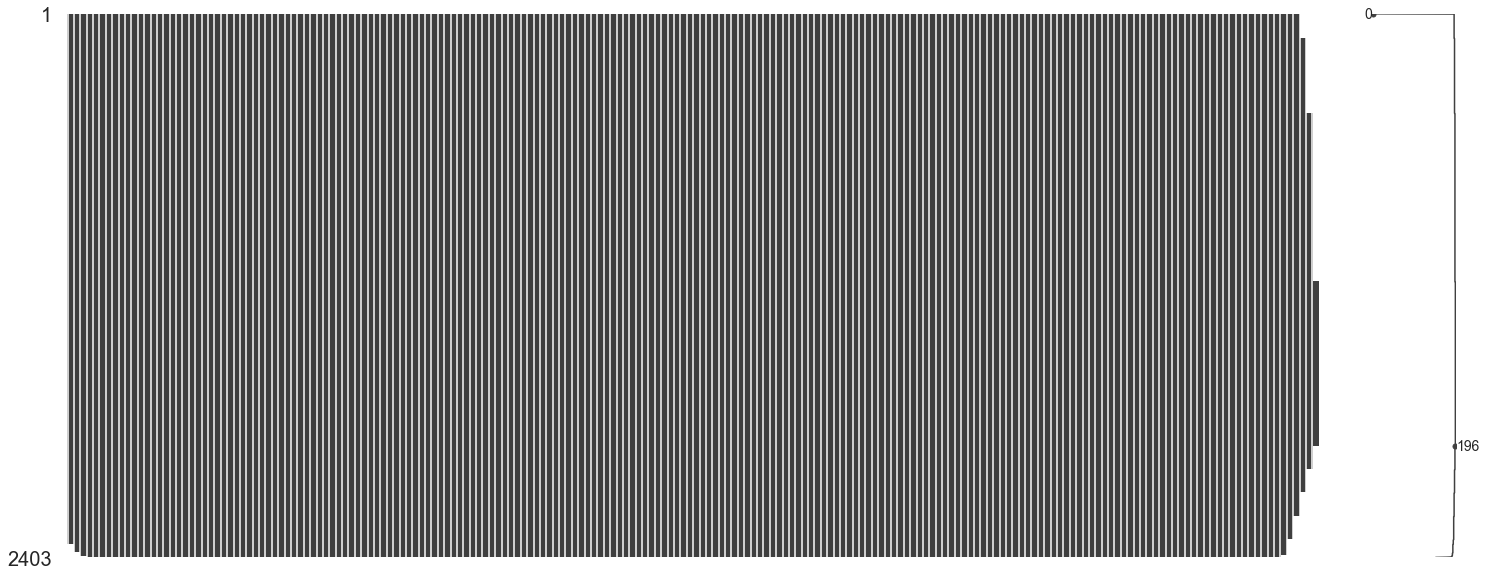

In [173]:
import missingno as msno
msno.matrix(z_df);

This would look more like a checkerboard if there were whole rows of data missing. Since all the nans are around the edges, we can drop these edge rows and columns to get a clean grid.

In [174]:
print(len(z_df))
print(*z_df.isna().sum())

2403
2403 59 21 5 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 10 79 182 394 829 1676


In [175]:
f'Drop all columns with more than {len(z_df) * 0.05} nans, then consider dropping the rest as rows.'

'Drop all columns with more than 120.15 nans, then consider dropping the rest as rows.'

The cell to drop columns below is commented out to prevent running it multiple times. Uncomment it, run it once, and then recomment it to prevent accidental loss of data.

In [176]:
# z_df.drop(columns=z_df.columns[[0, -1, -2, -3, -4]], inplace=True)
print(*z_df.isna().sum())

59 21 5 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 10 79


Now the rest of the nans can be cleaned up by dropping just three rows

In [177]:
z_df.dropna(axis=0, inplace=True)
z_df

,5.12,6.12,7.12,8.12,9.12,10.12,11.12,12.12,13.12,14.12,...,187.12,188.12,189.12,190.12,191.12,192.12,193.12,194.12,195.12,196.12
1.531848e+07,14.239120,14.197892,14.120385,14.183533,14.177953,14.100703,13.851424,13.837088,12.623838,11.932778,...,7.074763,7.058592,7.050526,7.043378,7.040205,7.035856,7.038597,7.016340,7.009253,7.012501
1.531854e+07,14.226363,14.221012,14.210943,14.090408,14.032935,13.983300,12.801985,13.000087,11.998454,11.847009,...,7.279637,7.272901,7.240001,7.199019,7.156269,7.101412,7.100403,7.097658,7.095298,7.091719
1.531860e+07,14.213606,14.170973,14.111121,14.363632,14.302021,14.101116,12.881438,12.688296,11.618997,11.278748,...,7.151859,7.143864,7.144203,7.134701,7.142472,7.130818,7.118297,7.111259,7.115614,7.136021
1.531866e+07,14.194031,14.120934,14.011299,14.521989,14.460151,14.142456,12.963377,12.452501,12.758078,11.334977,...,7.257718,7.252802,7.252564,7.235814,7.215926,7.208012,7.204803,7.194276,7.194837,7.184467
1.531872e+07,14.178797,14.047812,13.911478,14.367444,14.301861,13.985794,12.869543,12.399282,12.618458,11.285852,...,7.342397,7.333815,7.333184,7.303140,7.269075,7.262869,7.262194,7.246321,7.218759,7.202921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.545762e+07,12.009427,11.969547,11.948662,11.957151,11.951459,11.951264,11.950559,11.952439,11.952135,11.951317,...,8.743345,8.720970,8.717754,8.718795,8.702370,8.700583,8.692802,8.692991,8.676325,8.531894
1.545768e+07,12.010936,11.974380,11.958668,11.960412,11.960536,11.959915,11.959270,11.960162,11.959669,11.959297,...,8.786390,8.748656,8.735592,8.721730,8.698430,8.706427,8.677161,8.673193,8.629320,8.534748
1.545774e+07,12.009219,11.979283,11.968675,11.969587,11.969181,11.969323,11.968919,11.970177,11.968905,11.967400,...,8.741195,8.737502,8.726418,8.711138,8.692003,8.653904,8.643551,8.628373,8.617202,8.537602
1.545780e+07,12.005991,11.984219,11.978319,11.978558,11.977676,11.978971,11.978503,11.975655,11.976799,11.975344,...,8.797337,8.794772,8.792132,8.789891,8.784313,8.775614,8.771980,8.767803,8.752665,8.540456


In [178]:
1 - len(z_df) / 2403

0.032875572201414904

Only lost 3.28% of the observations and 5 meters of depth.

Now get a datetime column back.

In [179]:
# Get a column of the timestamps to convert then back to human-readable times
z_df['time'] = z_df.index

In [180]:
# Do conversions, then reset the index to be time
z_df['time'] = 100000000000 * z_df['time']
z_df['time'] = pd.to_datetime(z_df['time'])
z_df

,5.12,6.12,7.12,8.12,9.12,10.12,11.12,12.12,13.12,14.12,...,188.12,189.12,190.12,191.12,192.12,193.12,194.12,195.12,196.12,time
1.531848e+07,14.239120,14.197892,14.120385,14.183533,14.177953,14.100703,13.851424,13.837088,12.623838,11.932778,...,7.058592,7.050526,7.043378,7.040205,7.035856,7.038597,7.016340,7.009253,7.012501,2018-07-17 17:18:50.061576192
1.531854e+07,14.226363,14.221012,14.210943,14.090408,14.032935,13.983300,12.801985,13.000087,11.998454,11.847009,...,7.272901,7.240001,7.199019,7.156269,7.101412,7.100403,7.097658,7.095298,7.091719,2018-07-17 18:58:50.061576192
1.531860e+07,14.213606,14.170973,14.111121,14.363632,14.302021,14.101116,12.881438,12.688296,11.618997,11.278748,...,7.143864,7.144203,7.134701,7.142472,7.130818,7.118297,7.111259,7.115614,7.136021,2018-07-17 20:38:50.061576192
1.531866e+07,14.194031,14.120934,14.011299,14.521989,14.460151,14.142456,12.963377,12.452501,12.758078,11.334977,...,7.252802,7.252564,7.235814,7.215926,7.208012,7.204803,7.194276,7.194837,7.184467,2018-07-17 22:18:50.061576192
1.531872e+07,14.178797,14.047812,13.911478,14.367444,14.301861,13.985794,12.869543,12.399282,12.618458,11.285852,...,7.333815,7.333184,7.303140,7.269075,7.262869,7.262194,7.246321,7.218759,7.202921,2018-07-17 23:58:50.061576192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.545762e+07,12.009427,11.969547,11.948662,11.957151,11.951459,11.951264,11.950559,11.952439,11.952135,11.951317,...,8.720970,8.717754,8.718795,8.702370,8.700583,8.692802,8.692991,8.676325,8.531894,2018-12-25 18:18:50.061576192
1.545768e+07,12.010936,11.974380,11.958668,11.960412,11.960536,11.959915,11.959270,11.960162,11.959669,11.959297,...,8.748656,8.735592,8.721730,8.698430,8.706427,8.677161,8.673193,8.629320,8.534748,2018-12-25 19:58:50.061576192
1.545774e+07,12.009219,11.979283,11.968675,11.969587,11.969181,11.969323,11.968919,11.970177,11.968905,11.967400,...,8.737502,8.726418,8.711138,8.692003,8.653904,8.643551,8.628373,8.617202,8.537602,2018-12-25 21:38:50.061576192
1.545780e+07,12.005991,11.984219,11.978319,11.978558,11.977676,11.978971,11.978503,11.975655,11.976799,11.975344,...,8.794772,8.792132,8.789891,8.784313,8.775614,8.771980,8.767803,8.752665,8.540456,2018-12-25 23:18:50.061576192


---
### Append CUTI data

In [181]:
CUTI_data = pd.read_csv('../../coastal_upwelling_output/CUTI_daily.csv',
                  parse_dates=[[0,1,2]],
                  infer_datetime_format=True)
CUTI_data.rename(columns={'year_month_day':'time'},inplace=True)

In [182]:
CUTI_data = CUTI_data[CUTI_data['time'].dt.year == 2018][['time', '44N']].reset_index(drop=True)
CUTI_data

,time,44N
0,2018-01-01,0.095
1,2018-01-02,-0.207
2,2018-01-03,0.648
3,2018-01-04,0.222
4,2018-01-05,-0.682
...,...,...
360,2018-12-27,0.180
361,2018-12-28,-0.339
362,2018-12-29,-0.447
363,2018-12-30,-0.508


First, append the CUTI data according to time. I couldn't get this to work using z_df.index, so I added a time column back only to delete it again after. 

In [183]:
for month in range(1, 13):
    for day in range(1, 32):
        try:
            indices = z_df[(z_df['time'].dt.month == month) & (z_df['time'].dt.day == day)].index
            cuti_value = CUTI_data.loc[(CUTI_data['time'].dt.month == month) & (CUTI_data['time'].dt.day == day)]['44N'].values[0]
#             print(month, day, cuti_value)
            z_df.loc[indices,'CUTI'] = cuti_value
        except:
            pass

We can finally turn time back into the index.

In [184]:
z_df.set_index('time', inplace=True)

Then create a binary target variable for classification modeling.

In [186]:
z_df['upwelling'] = z_df['CUTI'].apply(lambda x: 1 if x > 0 else 0)
z_df

,5.12,6.12,7.12,8.12,9.12,10.12,11.12,12.12,13.12,14.12,...,189.12,190.12,191.12,192.12,193.12,194.12,195.12,196.12,CUTI,upwelling
time,,,,,,,,,,,,,,,,,,,,,
2018-07-17 17:18:50.061576192,14.239120,14.197892,14.120385,14.183533,14.177953,14.100703,13.851424,13.837088,12.623838,11.932778,...,7.050526,7.043378,7.040205,7.035856,7.038597,7.016340,7.009253,7.012501,0.978,1
2018-07-17 18:58:50.061576192,14.226363,14.221012,14.210943,14.090408,14.032935,13.983300,12.801985,13.000087,11.998454,11.847009,...,7.240001,7.199019,7.156269,7.101412,7.100403,7.097658,7.095298,7.091719,0.978,1
2018-07-17 20:38:50.061576192,14.213606,14.170973,14.111121,14.363632,14.302021,14.101116,12.881438,12.688296,11.618997,11.278748,...,7.144203,7.134701,7.142472,7.130818,7.118297,7.111259,7.115614,7.136021,0.978,1
2018-07-17 22:18:50.061576192,14.194031,14.120934,14.011299,14.521989,14.460151,14.142456,12.963377,12.452501,12.758078,11.334977,...,7.252564,7.235814,7.215926,7.208012,7.204803,7.194276,7.194837,7.184467,0.978,1
2018-07-17 23:58:50.061576192,14.178797,14.047812,13.911478,14.367444,14.301861,13.985794,12.869543,12.399282,12.618458,11.285852,...,7.333184,7.303140,7.269075,7.262869,7.262194,7.246321,7.218759,7.202921,0.978,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-25 18:18:50.061576192,12.009427,11.969547,11.948662,11.957151,11.951459,11.951264,11.950559,11.952439,11.952135,11.951317,...,8.717754,8.718795,8.702370,8.700583,8.692802,8.692991,8.676325,8.531894,0.171,1
2018-12-25 19:58:50.061576192,12.010936,11.974380,11.958668,11.960412,11.960536,11.959915,11.959270,11.960162,11.959669,11.959297,...,8.735592,8.721730,8.698430,8.706427,8.677161,8.673193,8.629320,8.534748,0.171,1
2018-12-25 21:38:50.061576192,12.009219,11.979283,11.968675,11.969587,11.969181,11.969323,11.968919,11.970177,11.968905,11.967400,...,8.726418,8.711138,8.692003,8.653904,8.643551,8.628373,8.617202,8.537602,0.171,1


In [187]:
z_df['upwelling'].value_counts(normalize=True)

1    0.60327
0    0.39673
Name: upwelling, dtype: float64

Save it for modeling!

In [188]:
z_df.to_csv('../../coastal_upwelling_output/interpolated.csv')

---
### Other griddata options
If you're curious to see how `griddata`'s other methods interpolate this data, run the cells below. Warning, they take a few minutes!

In [ ]:
# data coordinates and values
x = df_resampled.time_.astype(np.int64) / 100000000000 
y = df_resampled.seawater_pressure 
z = df_resampled.seawater_temperature 

In [118]:
# interpolate
zi_nearest = griddata((x,y),z,(xi,yi),method='nearest', rescale=True)
zi_linear = griddata((x,y),z,(xi,yi),method='linear', rescale=True)
zi_cubic = griddata((x,y),z,(xi,yi),method='cubic', rescale=True)

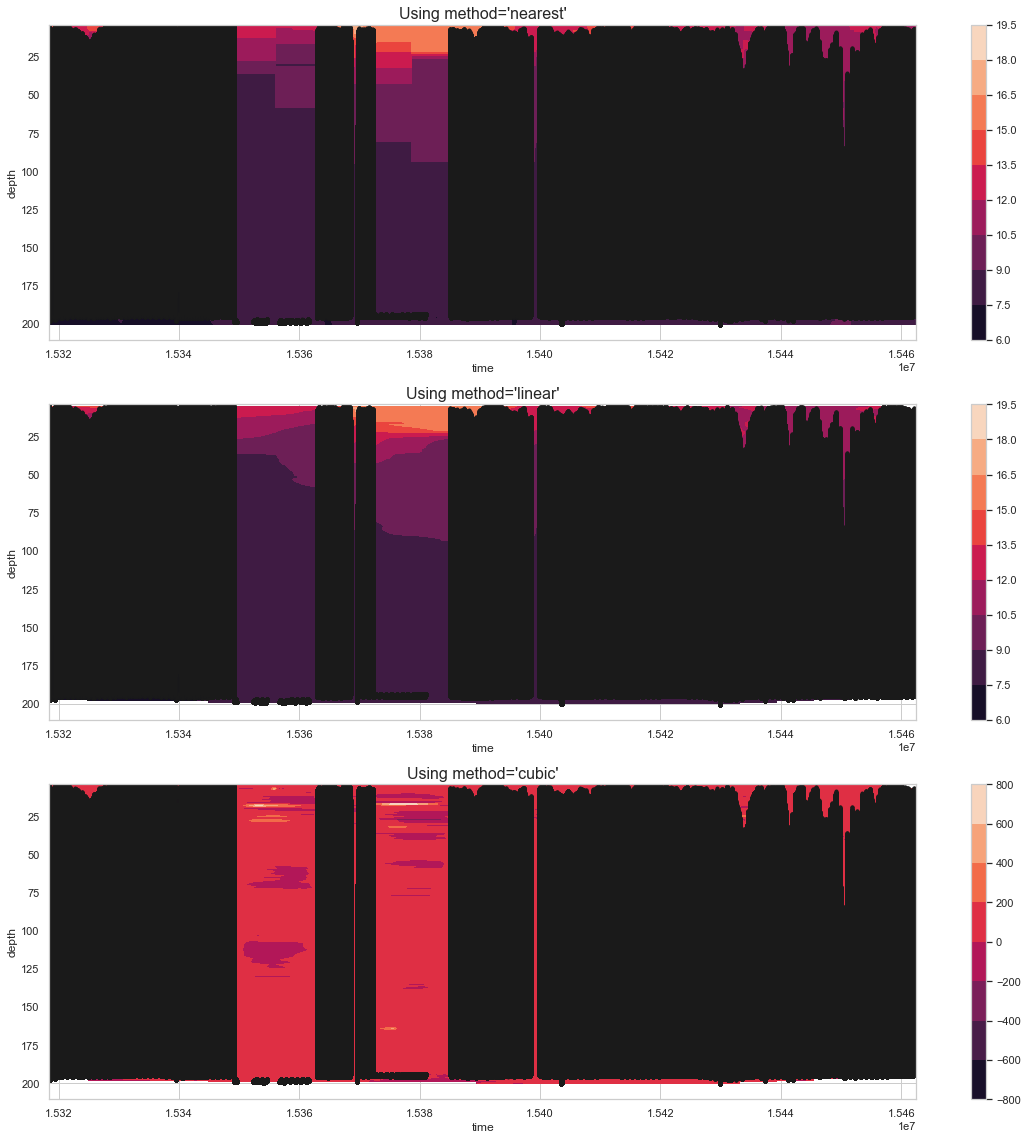

In [119]:
# plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,16))

cs1 = ax1.contourf(xi,yi,zi_nearest)
plt.colorbar(cs1, ax=ax1)
ax1.plot(x,y,'k.')
ax1.set_xlabel('time')
ax1.set_ylabel('depth')
ax1.invert_yaxis()
ax1.set_title("Using method='nearest'",fontsize=16)

cs2 = ax2.contourf(xi,yi,zi_linear)
plt.colorbar(cs2, ax=ax2)
ax2.plot(x,y,'k.')
ax2.set_xlabel('time')
ax2.set_ylabel('depth')
ax2.invert_yaxis()
ax2.set_title("Using method='linear'",fontsize=16)

cs3 = ax3.contourf(xi,yi,zi_cubic)
plt.colorbar(cs3, ax=ax3)
ax3.plot(x,y,'k.')
ax3.set_xlabel('time')
ax3.set_ylabel('depth')
ax3.invert_yaxis()
ax3.set_title("Using method='cubic'",fontsize=16)

plt.tight_layout();
plt.savefig('../figures/gridded_data.png')